In [1]:
# Compare a HOD model with OD model on test data

import madmom
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from models.bock2013pret import get_model
from modules.analysis_funcs import get_segmented_data, get_test_peaks

def wbce(y_true, y_pred):
    y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1-1e-7)
    logits = tf.keras.backend.log(y_pred/(1-y_pred))
    return tf.nn.weighted_cross_entropy_with_logits(
        y_true, logits, W
    )

In [2]:
audio_fname = "datasets/slurtest_add/slurtest_add_audio/slurtest05_FK.wav"
audio, sample_rate = madmom.io.audio.load_wave_file(audio_fname)

label_fname = "datasets/slurtest_add/new_annotations/slurtest05_FK.txt"

true_onsets = np.loadtxt(label_fname, usecols=0)
cnn_input = get_segmented_data(audio)

/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [3]:
model, _ = get_model()


In [44]:
model_path = "results/cnn-training-221210/fold_0_sa_ir_strat-0.001-500eps-standard-trainable-noextend-dropout0.8"
model = tf.keras.models.load_model(model_path + "_model", custom_objects = {"wbce": wbce})
epoch = 20
model.load_weights(model_path + "_cp_{:04d}.ckpt".format(epoch))
cnn_output_2 = model.predict(cnn_input)

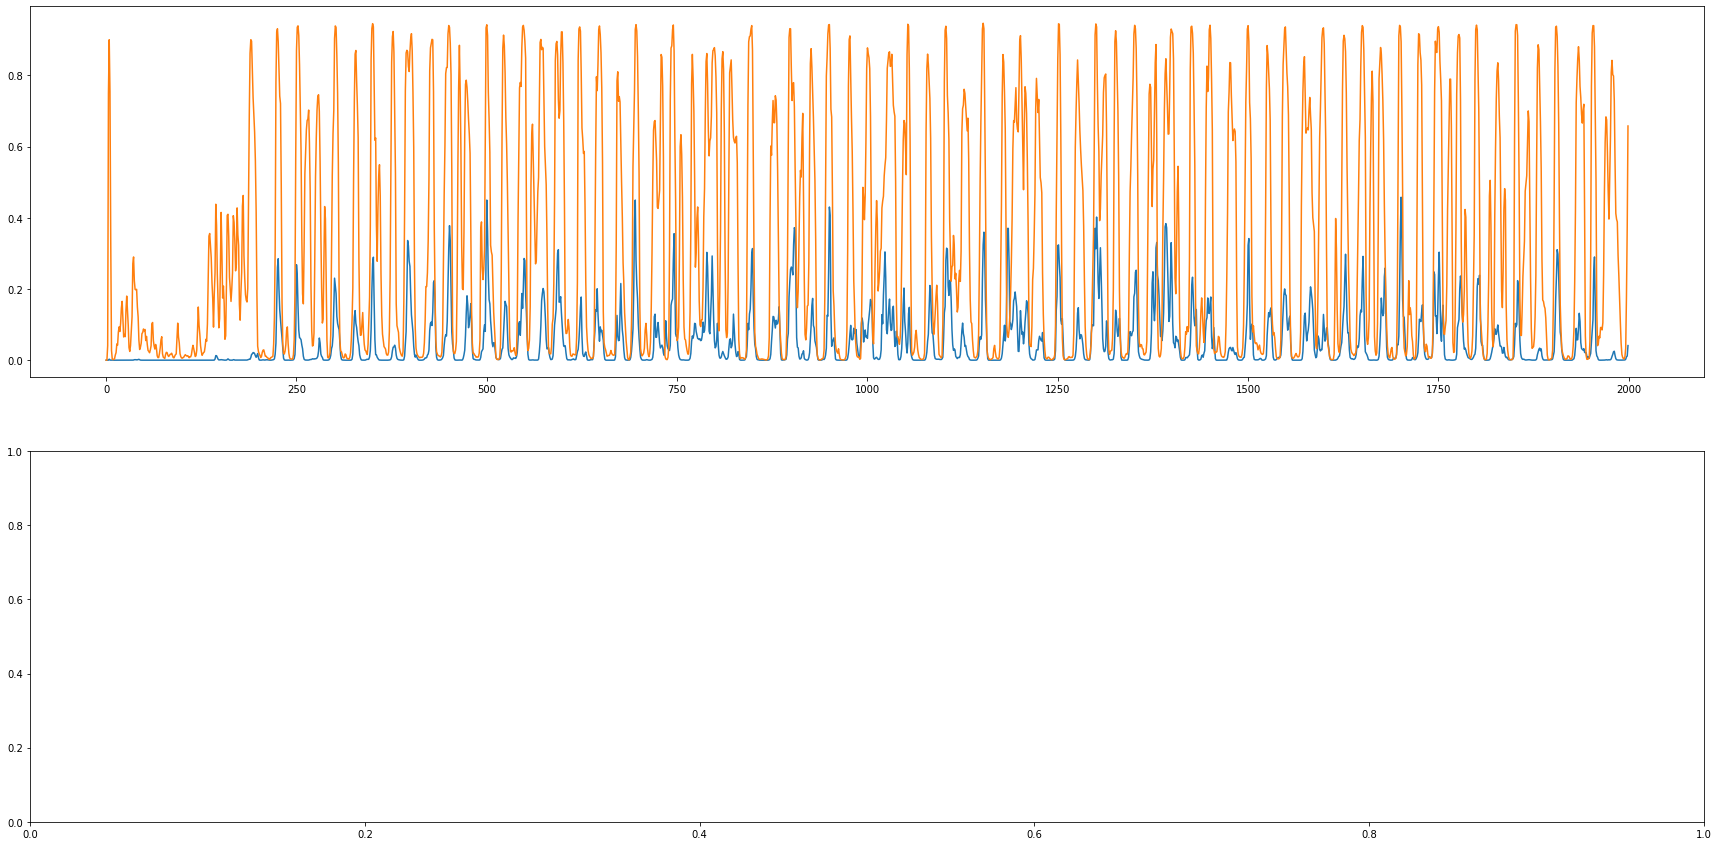

In [46]:
fig, axs = plt.subplots(2, 1, figsize=(30,15))
axs[0].plot(cnn_output[:num_show,0])
axs[0].plot(cnn_output_2[:num_show,0])

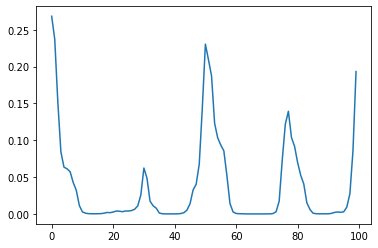

In [63]:
plt.plot(cnn_output[250:350])

In [50]:
cnn_onsets = madmom.features.onsets.peak_picking(
                                        activations=cnn_output, 
                                        threshold=0.25, 
    )[0].astype(np.float32)
print(len(cnn_onsets))
print(len(true_onsets))

95
95


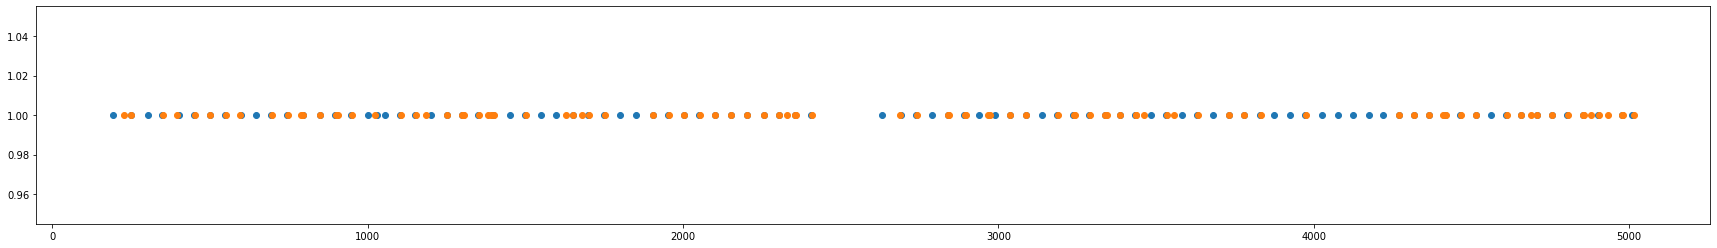

In [60]:
plt.figure(figsize=(30,4))

plt.scatter(true_onsets*100, np.ones_like(true_onsets))
plt.scatter(cnn_onsets, np.ones_like(cnn_onsets))